This wouldn't be a quantum dynamics simulation without some time dependence!

In [1]:
from IPython.display import HTML
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
np.set_printoptions(precision=4, suppress=True)

from transit_chem.basis import HarmonicOscillator, EigenBasis
from transit_chem.operators import Hamiltonian, Overlap

from transit_chem.time_evolution import TimeEvolvingState, TimeEvolvingObservable

## Time independent Solution

Hoisting the time independent solution from the previous tutorial:

In [2]:
def potential(x):
    return -0.5*x**2 + 0.04 * x**4 + 2

basis = [
    HarmonicOscillator(n=0, center=-2),
    HarmonicOscillator(n=1, center=-2), 
    HarmonicOscillator(n=0, center=2), 
    HarmonicOscillator(n=1, center=2),
]

H = Hamiltonian(potential).matrix(basis)
S = Overlap().matrix(basis)

eig_basis = EigenBasis.from_basis(basis, H, S)
eig_basis

EigenBasis(states=(0.6992 * HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0)
 + -0.0869 * HarmonicOscillator(n=1, center=-2, mass=1.0, omega=1.0)
 + 0.6992 * HarmonicOscillator(n=0, center=2, mass=1.0, omega=1.0)
 + 0.0869 * HarmonicOscillator(n=1, center=2, mass=1.0, omega=1.0), 0.6967 * HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0)
 + -0.1280 * HarmonicOscillator(n=1, center=-2, mass=1.0, omega=1.0)
 + -0.6967 * HarmonicOscillator(n=0, center=2, mass=1.0, omega=1.0)
 + -0.1280 * HarmonicOscillator(n=1, center=2, mass=1.0, omega=1.0), -0.0577 * HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0)
 + -0.6608 * HarmonicOscillator(n=1, center=-2, mass=1.0, omega=1.0)
 + -0.0577 * HarmonicOscillator(n=0, center=2, mass=1.0, omega=1.0)
 + 0.6608 * HarmonicOscillator(n=1, center=2, mass=1.0, omega=1.0), 0.1599 * HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0)
 + 0.7476 * HarmonicOscillator(n=1, center=-2, mass=1.0, omega=1.0)
 + -0.1599 * HarmonicOscillator(n=0, 

## Time evolving states

To get a state evolving in time, we need the eigenbasis and an initial state. 



In [3]:
initial = HarmonicOscillator(n=0, center=-2)
time_state = TimeEvolvingState(initial, eig_basis)
time_state

TimeEvolvingState(initial_state=HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0))

Time evolving states are simply functions of `x` and `t`, namely:

In [4]:
for t in range(4):
    val = time_state(0.0, t)
    print(f"State's wavefunction has value {val} at time {t}")

State's wavefunction has value (0.1016537883064175+0j) at time 0
State's wavefunction has value (0.009977734082449926-0.08967532301214656j) at time 1
State's wavefunction has value (-0.05664250439519702-0.01945510321670284j) at time 2
State's wavefunction has value (-0.027585791118214437+0.010539634672632739j) at time 3


To get a better feel for this, we can plot the wave function over time:

In [5]:
%%capture  
# matplotlib nonsense

def animate_state(initial_state, time_dependent_state):
    fig = plt.figure()
    ax = plt.axes(xlim=(-4, 4), ylim=(-1, 4))
    x = np.linspace(-4, 4, 1000)
    ax.plot(x, potential(x), "k--")
    ax.plot(x, initial_state(x) * np.conj(initial_state(x)) + initial.energy, color="C1", label="$\phi(0)$")
    
    line, = ax.plot([], [], color="C0", label="$\phi(t)$")
    ax.legend(loc="upper center")


    def density(x, t):
        return time_dependent_state(x, t) * np.conj(time_dependent_state(x, t))


    def init():
        line.set_data([], [])
        return line,

    def animate(t):
        y = density(x, t / 10) + initial.energy
        line.set_data(x, y)
        return line,

    anim = FuncAnimation(fig, animate, init_func=init,
                                   frames=400, interval=20, blit=True)

    return anim
    
a = animate_state(initial, time_state)

In [6]:
HTML(a.to_html5_video())

/home/evan/.cache/pypoetry/virtualenvs/transit-chem-py3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)




Here we can even get a glimpse at some tunneling! If you squint really hard, you can see
some movement in the right well.


Now would be an interesting time to look at what happens if we change up the initial state. 

In [7]:
%%capture
# matplotlib nonsense again
initial_state_2 = HarmonicOscillator(n=1, center=-2)
time_state_2 = TimeEvolvingState(initial_state_2, eig_basis)
anim = animate_state(initial_state_2, time_state_2)

In [8]:
HTML(anim.to_html5_video())

/home/evan/.cache/pypoetry/virtualenvs/transit-chem-py3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



Whoa! A big difference! Notice how the state is much more mobile. Since we started off
in the `n=1` state rather than the `n=2`, it has much more energy to cross the barrier. 

## Time evolving Observables

---

So we've seen how to look at the time evolution of some initial state in a potential. Next we want to
look at how observables change over time. Let's use the second of our initial states, it should be
more interesting. If we look at the time evolution of the density in the left and right
wells, we can get a feel for the oscillation of the particle's density over time. 

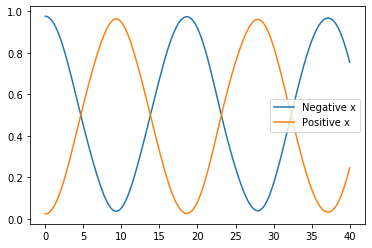

In [9]:
positive_density = time_state_2.observable(Overlap(lower_limit=0.0), hermitian=True)
neg_density = time_state_2.observable(Overlap(upper_limit=0.0), hermitian=True)

fig, ax = plt.subplots()

times = np.linspace(0, 40, 400)
ax.plot(times, [neg_density(t) for t in times], label="Negative x")
ax.plot(times, [positive_density(t) for t in times], label="Positive x")

_ = ax.legend()

Notice how the density oscillates between the left well and the right well. The period
is roughly 20 atomic units of time, which if you look again at the second animation above
(which was animated for 40 atu), you can see the pattern repeating itself. 


Since this is the type of thing we're doing in the analysis, it's been made easy to do. 
The code below does the same exact thing we just did.

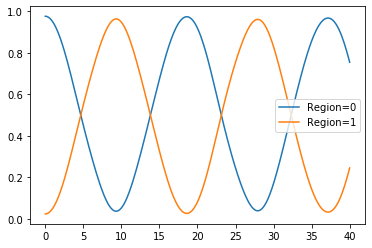

In [10]:
from transit_chem.hopping_matrix import OccupancyProbabilites

occprobs = OccupancyProbabilites.from_1d_state(time_state_2, borders=(-np.inf, 0.0, np.inf))

fig, ax = plt.subplots()
occ_probs_over_time = zip(*[occprobs(t) for t in times])
for i, ot in enumerate(occ_probs_over_time):
    ax.plot(times, ot, label=f"Region={i}")
_ = ax.legend()

In [11]:
from transit_chem import __version__
print(__version__)

0.6.2
